In [7]:
import numpy as np
import os

# Imports nécessaires pour construire un modèle LeNet 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling

# Pour importer le datasets
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Pour la compilation du modèle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Pour visualiser les performances
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

print(tf.__version__)
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# Chargement du dataset
#dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample"
dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample_balanced"
img_size = (224, 224)  # Taille cible
batch_size = 32
class_names = sorted(os.listdir(dir_name))
nb_class = len(class_names)

train_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=42
)

val_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)

# Ajout d'optimisation : mise en cache et préchargement
#train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

def display_results(model_history, model_name):
    # Récupérer les données d'entraînement et de validation
    train_loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    train_accuracy =  model_history.history["accuracy"]
    val_accuracy = model_history.history["val_accuracy"]
    
    plt.figure(figsize=(20, 8))
    
    # Tracer la perte
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(model_name + ": Perte d'entraînement et de validation")
    plt.ylabel('Perte ')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    # Tracer l'erreur absolue moyenne (MAE)
    plt.subplot(122)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title(model_name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    plt.show()

2.19.0
Num GPUs Available:  1
Found 54000 files belonging to 27 classes.
Using 43200 files for training.
Found 54000 files belonging to 27 classes.
Using 10800 files for validation.


## Entrainement du modèle

Epoch 1/30
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 229s 168ms/step - accuracy: 0.0477 - loss: 6.0752 - val_accuracy: 0.0994 - val_loss: 3.2072 - learning_rate: 1.0000e-04
Epoch 2/30
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 203s 150ms/step - accuracy: 0.0682 - loss: 3.3228 - val_accuracy: 0.1431 - val_loss: 3.0529 - learning_rate: 1.0000e-04
Epoch 3/30
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 209s 154ms/step - accuracy: 0.1061 - loss: 3.1389 - val_accuracy: 0.2166 - val_loss: 2.7676 - learning_rate: 1.0000e-04
Epoch 4/30
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - accuracy: 0.1434 - loss: 2.9623 - val_accuracy: 0.2728 - val_loss: 2.5714 - learning_rate: 1.0000e-04
Epoch 5/30
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 194s 144ms/step - accuracy: 0.1782 - loss: 2.8232 - val_accuracy: 0.2994 - val_loss: 2.4566 - learning_rate: 1.0000e-04
Epoch 6/30
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 193s 143ms/step - accuracy: 0.2069 - loss: 2.7263 - val_accuracy: 0.3236 - val_loss: 2.3639 - learning_rate: 1.0000e-04
Epoch 7/30
1350/1350 ━━━━━━━

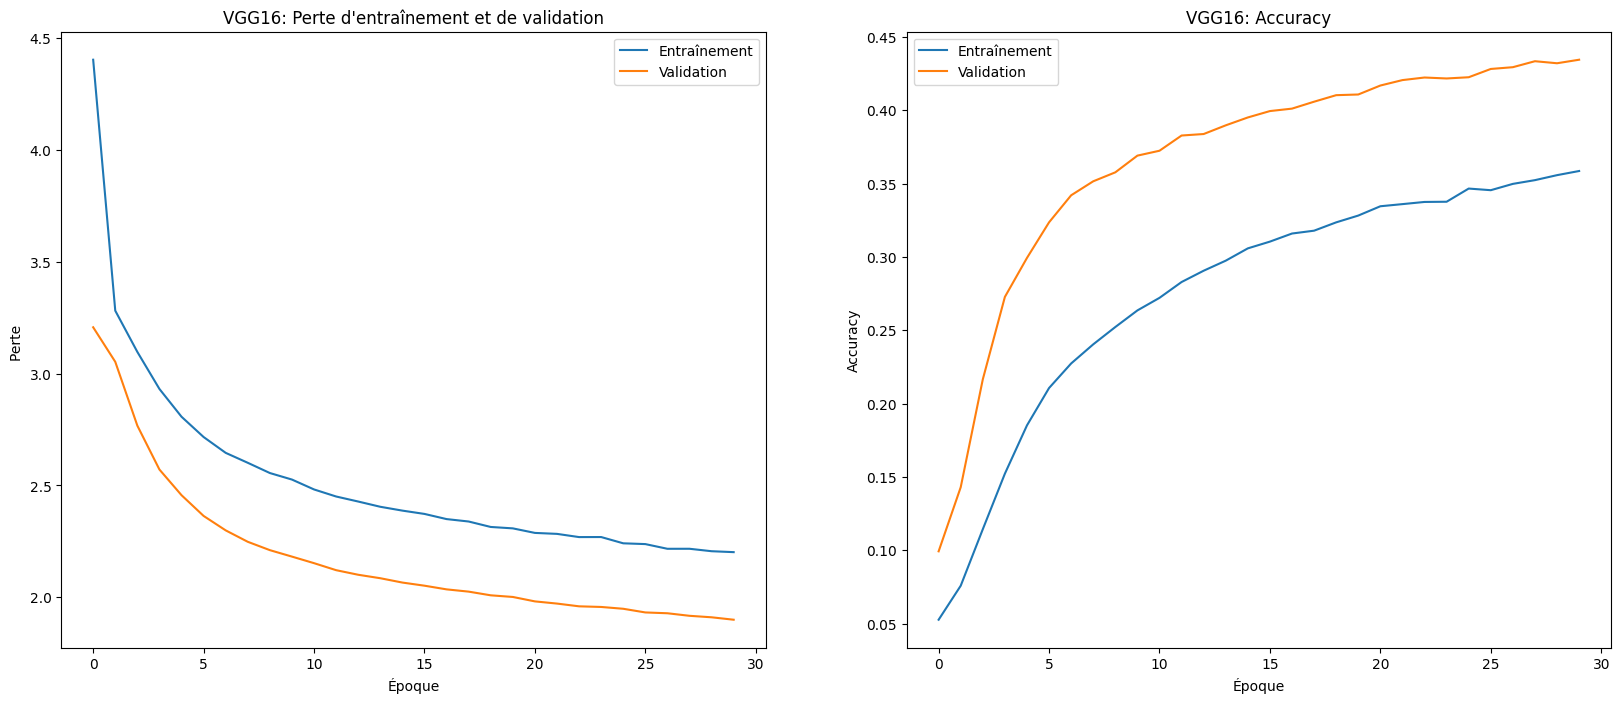

In [9]:
import tensorflow as tf 

base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
#base_model.trainable = False  # Geler d'abord le modèle de base

# Dégeler les dernières couches du modèle de base
base_model.trainable = False

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

model = tf.keras.Sequential([
    # Augmentation de données
    data_augmentation,

     # Prétraitement spécifique au modèle
    tf.keras.layers.Lambda(lambda x: tf.keras.applications.vgg16.preprocess_input(x)),

    # Modèle de base
    base_model,

    # Couches de classification
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(nb_class, activation='softmax')
])

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),                 
    metrics=['accuracy'])  


model_history = model.fit(train_ds,           
                           validation_data=val_ds,
                           epochs=30,
                           callbacks=[lr_reducer, early_stopping])  

# Analyse de l'entainement
print("Analyse entraintement")
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")
display_results(model_history, "VGG16")